## 复现TrtPose

本文推荐英伟达开源的一个自底向上姿态模型，无需先进行人物检测，直接对姿态关键点进行估计，再进行多人匹配， 运行效率非常高。

TrtPose是一款轻量级，推理速度极快的姿态估计模型，作者在本地基于C++、Cuda和Tensorrt实现的TrtPose,单帧推理不足2ms， 在JetsonNano上也运行得非常快。

原代码基于PyTorch实现: https://github.com/NVIDIA-AI-IOT/trt_pose


### 基于PaddlePaddle组网

网络结构相对比较简单，以Resnet18作为BackBone， Head部分采用CmapPafHeadAttention， 包含了注意力模块和UpsampleCBR上采样模块。

Resnet18可以直接使用paddle.vision.models里的， 所以搭建起来非常方便。

```

class ResNetBackbone(nn.Layer):
    def __init__(self, resnet):
        super(ResNetBackbone, self).__init__()
        self.resnet = resnet
 
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x) # /4
        x = self.resnet.layer2(x) # /8
        x = self.resnet.layer3(x) # /16
        x = self.resnet.layer4(x) # /32
        return x

class UpsampleCBR(nn.Sequential):
    def __init__(self, input_channels, output_channels, count=1, num_flat=0):
        layers = []
        for i in range(count):
            if i == 0:
                inch = input_channels
            else:
                inch = output_channels
                
            layers += [
                nn.Conv2DTranspose(inch, output_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2D(output_channels),
                nn.ReLU()
            ]
            for i in range(num_flat):
                layers += [
                    nn.Conv2D(output_channels, output_channels, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2D(output_channels),
                    nn.ReLU()
                ]
            
        super(UpsampleCBR, self).__init__(*layers)

class CmapPafHeadAttention(nn.Layer):
    def __init__(self, input_channels, cmap_channels, paf_channels, upsample_channels=256, num_upsample=0, num_flat=0):
        super(CmapPafHeadAttention, self).__init__()
        self.cmap_up = UpsampleCBR(input_channels, upsample_channels, num_upsample, num_flat)
        self.paf_up = UpsampleCBR(input_channels, upsample_channels, num_upsample, num_flat)
        self.cmap_att = nn.Conv2D(upsample_channels, upsample_channels, kernel_size=3, stride=1, padding=1)
        self.paf_att = nn.Conv2D(upsample_channels, upsample_channels, kernel_size=3, stride=1, padding=1)
        self.cmap_conv = nn.Conv2D(upsample_channels, cmap_channels, kernel_size=1, stride=1, padding=0)
        self.paf_conv = nn.Conv2D(upsample_channels, paf_channels, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        xc = self.cmap_up(x)
        ac =  nn.functional.sigmoid(self.cmap_att(xc))
        xp = self.paf_up(x)
        ap =  nn.functional.tanh(self.paf_att(xp))
        return self.cmap_conv(xc * ac), self.paf_conv(xp * ap)
    
```



### 模型后处理

自底向上目前有两种主流的方式， 第一种直接回归坐标, 思路直接，可以直接获得关键点位置，往往有更快的预测速度。然而，由于人体姿态的自由度很大，直接预测坐标的建模方式对神经网络的预测并不友好，预测精度受到了一定制约。第二种思路基于热图的方法在每个位置预测一个分数，来表征该位置属于关键点的置信度。根据预测的热图，进一步提取关键点的坐标位置。

TrtPose也是基于热图的方式，采用OpenPose的解码原理。所以后处理相对比较复杂，而且源代码是c++插件的方式， 这里我将其改成了python代码并简单做了相应的输出对齐。
模型推理的大致流程如下：


![](https://ai-studio-static-online.cdn.bcebos.com/2d7b517e48174d5883cb4378d0807d941dc44152ee974797b4979b151712875f)

更多详细的原理介绍可参考: https://docs.nvidia.com/isaac/isaac/packages/skeleton_pose_estimation/doc/2Dskeleton_pose_estimation.html




### 模型推理示例

```
%cd /home/aistudio/work/human
!python infer.py /home/aistudio/tmp/10p.jpeg
```

推理结果图片：

![](https://ai-studio-static-online.cdn.bcebos.com/017b56fb2ab047f581c97073d2d1817855a951fa81354e75b62752831a61509d)



## 训练自定义数据集

### AnimalPose5数据集

本数据集来源： https://github.com/noahcao/animal-pose-dataset

包含有5种类别(cow, sheep, horse, cat, dog), 数据标注按照COCO格式，对于每个实例标注有边界框[xmin, ymin, xmax, ymax]， 以及关键点的二维坐标[x, y, visible]

20 关键点: Two eyes, Throat, Nose, Withers, Two Earbases, Tailbase, Four Elbows, Four Knees, Four Paws.

In [2]:
# 解压你所挂载的数据集在目录下
!unzip -oq /home/aistudio/data/data127829/images.zip -d /home/aistudio/data
!cp /home/aistudio/data/data127829/keypoints.json /home/aistudio/data

# 查看数据集的目录结构
!ls /home/aistudio/data
!tree /home/aistudio/data -d

data127829  images  keypoints.json
/home/aistudio/data
├── data127829
└── images

2 directories


6117
image_path===> /home/aistudio/data/images/2007_000063.jpg


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


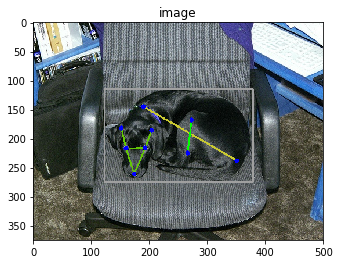

In [3]:
import cv2
import matplotlib.pyplot as plt
from work.animal.pre_visualize import visualize_img
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

img = visualize_img()
plt.figure("Image") # 图像窗口名称
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

### 模型训练

模型训练时间耗时太长， 可能原因是数据加载部分从C++插件方式转换成了python, 运行效率大幅降低。 目前训练的loss只能到0.001123及 0.001038

```
%cd /home/aistudio/work/animal/trt_pose_model.py
!python train.py
```

![](https://ai-studio-static-online.cdn.bcebos.com/bdc9673680484c8f9891d9671e70960e22c9a4d8bc09433b9fd5b28d52bd16fc)


### 模型推理

基于训练好的模型，可直接推理图片. 下面两条命令推理结果如下:

![](https://ai-studio-static-online.cdn.bcebos.com/0f570c06a8294eb9acd6ddb713992dcdf07a35c55e404ab88e53be477b16f9b6)

![](https://ai-studio-static-online.cdn.bcebos.com/3d5ae1ab8662422591266b55ed0bbb92a33ad167a5834f54a6c5c4e4f91e7fda)





In [13]:
%cd /home/aistudio/work/animal/
!python infer.py /home/aistudio/data/images/2007_000063.jpg

/home/aistudio/work/animal
W0227 23:02:13.061772  3542 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 23:02:13.065774  3542 device_context.cc:465] device: 0, cuDNN Version: 7.6.
(1, 21, 2, 100)
infer done


In [14]:
%cd /home/aistudio/work/animal/
!python infer.py /home/aistudio/data/images/ca80.jpeg

/home/aistudio/work/animal
W0227 23:03:01.010046  3622 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 23:03:01.014973  3622 device_context.cc:465] device: 0, cuDNN Version: 7.6.
(1, 21, 2, 100)
infer done


## 写在最后

本项目优化的空间还很大, 因为模型本来较小，数据集也不太多，训练的结果只能有个大概的样子，后期需要进一步更多的优化

## 关于作者

* 成都飞桨领航团团长
* PPDE
* AICA三期学员

我在AI Studio上获得钻石等级，点亮10个徽章，来互关呀~ 
https://aistudio.baidu.com/aistudio/personalcenter/thirdview/89442

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 